In [1]:
import cv2
import numpy as np

In [14]:

def padding_matrix(matrix, width, height, pad_size):
    """
    Description:
        - Pad the input matrix with zeros from the four direction with the specified padding size.

    Parameters:
        - matrix (numpy.ndarray): The input matrix.
        - width (int): The desired width of the padded matrix.
        - height (int): The desired height of the padded matrix.
        - pad_size (int): The size of padding to add around the matrix.

    Returns:
        numpy.ndarray: The padded matrix.
    """
    padded_matrix = np.zeros((height + 2 * pad_size, width + 2 * pad_size)) # zeros matrix 
    padded_matrix[pad_size:pad_size+height, pad_size:pad_size+width] = matrix  
    return padded_matrix



def convolve2d_optimized(input_matrix, convolution_kernel, mode='same'):
    """
    Perform a 2D convolution of an input matrix with a convolution kernel.

    Parameters:
    - input_matrix (numpy.ndarray): The input matrix to be convolved.
    - convolution_kernel (numpy.ndarray): The kernel used for the convolution.
    - mode (str): The mode of convolution, can be 'same' (default), 'valid', or 'full'.

    Returns:
    - output_matrix (numpy.ndarray): The result of the convolution.
    """

    # Get dimensions of input matrix and kernel
    input_height, input_width = input_matrix.shape
    kernel_size = convolution_kernel.shape[0]
    padding_size = kernel_size // 2

    # Pad the input matrix
    padded_matrix = padding_matrix(input_matrix, input_width, input_height, pad_size=padding_size)

    # Create an array of offsets for convolution
    offset_array = np.arange(-padding_size, padding_size + 1)

    # Create a meshgrid of indices for convolution
    x_indices, y_indices = np.meshgrid(offset_array, offset_array, indexing='ij')

    # Add the meshgrid indices to an array of the original indices
    i_indices = np.arange(padding_size, input_height + padding_size)[:, None, None] + x_indices.flatten()
    j_indices = np.arange(padding_size, input_width + padding_size)[None, :, None] + y_indices.flatten()

    # Use advanced indexing to get the regions for convolution
    convolution_regions = padded_matrix[i_indices, j_indices].reshape(input_height, input_width, kernel_size, kernel_size)

    # Compute the convolution by multiplying the regions with the kernel and summing the results
    output_matrix = np.sum(convolution_regions * convolution_kernel, axis=(2, 3))

    return output_matrix


In [15]:
def compute_gradient_2d(array):
    """
    Compute the gradient of a 2D array using finite differences.

    Parameters:
    - array (numpy.ndarray): The input 2D array.

    Returns:
    - dy, dx (tuple of numpy.ndarray): The gradients of the input array along the y and x directions.
    """
    dy = np.zeros_like(array)
    dx = np.zeros_like(array)

    # Compute the gradient for the interior points
    dy[1:-1, :] = (array[2:, :] - array[:-2, :]) / 2
    dx[:, 1:-1] = (array[:, 2:] - array[:, :-2]) / 2

    # Use forward difference for the first row and column
    dy[0, :] = array[1, :] - array[0, :]
    dx[:, 0] = array[:, 1] - array[:, 0]

    # Use backward difference for the last row and column
    dy[-1, :] = array[-1, :] - array[-2, :]
    dx[:, -1] = array[:, -1] - array[:, -2]

    return dy, dx


In [16]:
def harris_detection(img_path, window_size, k, threshold):
    """
    Detect corners in an image using the Harris corner detection algorithm.

    Args:
    - img_path (str): Path to the input image file.
    - window_size (int): Size of the window for computing the corner response function.
    - k (float): Harris detector free parameter in the range [0.04, 0.06].
    - threshold (float): Threshold value for corner detection.

    Returns:
    - corner_list (list): List of detected corners, each represented as [x, y, r] where x and y are the coordinates
                          of the corner and r is the corner response value.
    - output_img (numpy.ndarray): Image with detected corners highlighted in red.
    """
    corner_list = []  # List to store detected corners
    img = cv2.imread(img_path)  # Read input image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert image to grayscale
    output_img = cv2.cvtColor(gray.copy(), cv2.COLOR_GRAY2RGB)  # Convert grayscale image to RGB for visualization

    # Check if the image exists
    if img is None:
        print('Invalid image path:', img_path)
        return None, None
    else:
        print('Image successfully read...')

    height = img.shape[0]  # Get height of the image
    width = img.shape[1]   # Get width of the image

    # Compute image gradients
    K_X = np.array([[-1, -2, 0, 2, 1],
                [-2, -3, 0, 3, 2],
                [-3, -5, 0, 5, 3],
                [-2, -3, 0, 3, 2],
                [-1, -2, 0, 2, 1]])

    K_Y = K_X.T  # The kernel for vertical edges is the transpose of the kernel for horizontal edges

    dx,dy = convolve2d_optimized(gray, K_X, mode='same'),convolve2d_optimized(gray, K_Y, mode='same') 

    # Compute products and second derivatives
    Ixx = dx**2
    Ixy = dy*dx
    Iyy = dy**2

    offset = int(window_size / 2)
    y_range = height - offset
    x_range = width - offset

    print("Finding Corners...")
    for y in range(offset, y_range):
        for x in range(offset, x_range):
            start_y = y - offset
            end_y = y + offset + 1
            start_x = x - offset
            end_x = x + offset + 1

            # Extract windows for second moment matrix
            windowIxx = Ixx[start_y:end_y, start_x:end_x]
            windowIxy = Ixy[start_y:end_y, start_x:end_x]
            windowIyy = Iyy[start_y:end_y, start_x:end_x]

            # Compute sums of the second moment matrix
            Sxx = windowIxx.sum()
            Sxy = windowIxy.sum()
            Syy = windowIyy.sum()

            # Compute determinant and trace of the second moment matrix
            det = (Sxx * Syy) - (Sxy**2)
            trace = Sxx + Syy

            # Compute corner response
            r = det - k * (trace**2)

            # Apply threshold and store detected corners
            if r > threshold:
                corner_list.append([x, y, r])
                output_img[y, x] = (0, 0, 255)  # Highlight detected corners in red

    return corner_list, output_img


# CV Lib Harris


Detecting Corners Started!
Image successfully read...
Finding Corners...
Time consumed is 3.6181271076202393 seconds


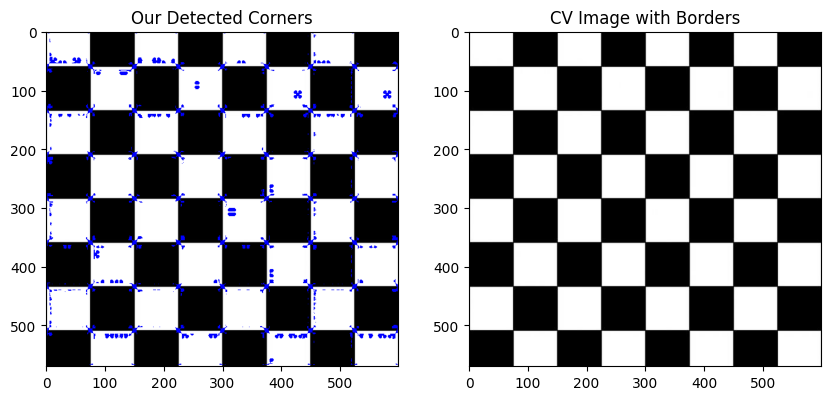

In [19]:
# Python program to illustrate 
# corner detection with 
# Harris Corner Detection Method 
import os
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt

# To solve the problem of the icons with relative path
# os.chdir(os.path.dirname(os.path.abspath(__file__)))
current_path = os.getcwd()


# path to input image specified and 
# image is loaded with imread command 
image_path = os.path.join(current_path, "Harris-Corner-600x570.jpg")
image = cv2.imread(image_path)

# # convert the input image into 
# # grayscale color space 
# operatedImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

# # modify the data type 
# # setting to 32-bit floating point 
# operatedImage = np.float32(operatedImage) 

# # apply the cv2.cornerHarris method 
# # to detect the corners with appropriate 
# # values as input parameters 
# dest = cv2.cornerHarris(operatedImage, 2, 5, 0.07) 

# # Results are marked through the dilated corners 
# dest = cv2.dilate(dest, None) 

# # Reverting back to the original image, 
# # with optimal threshold value 
# image[dest > 0.01 * dest.max()]=[0, 0, 255] 

k = 0.04
window_size = 5
threshold = 10000
print ("Detecting Corners Started!")
start = time.time()
corner_list, corner_img = harris_detection("Harris-Corner-600x570.jpg", window_size, k, threshold)
finish = time.time()

# Display the images using matplotlib
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(corner_img, cmap='gray')
plt.title('Our Detected Corners')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('CV Image with Borders')
print(f"Time consumed is {finish - start} seconds")
plt.show()
